In [1]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.cosmology import Planck15 as cosmo #Planck 2015
from astropy.cosmology import z_at_value

import get_ZdepSFRD as Z_SFRD
import importlib
import paths
import requests
import illustris_python as il
import illustris_python.groupcat as gc
import illustris_python.snapshot as sn

In [2]:
TNG  = 100
lvl = 1
TNGpath = "/Users/sashalvna/Research/TNGdata/TNG%s" % (TNG)
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"e36226423a0cc5e62f2e553f39b44238"}

In [3]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

In [4]:
#get basic snapshots information (redshift, url) for each of the 100 snapshots

r = get(baseUrl) #path to all Illustris TNG simulations
names = [sim['name'] for sim in r['simulations']] #names of all available simulations
i = names.index('TNG%s-%s' % (TNG, lvl)) #index of specific simulation
sim = get( r['simulations'][i]['url'] ) #get path to that simulation
snaps = get( sim['snapshots'] ) #get path to snapshots for that simulation
nfiles = sim['num_files_snapshot'] #number files per snapshot

In [5]:
def get_TNGsnapcols(TNGpath, TNG, lvl, snap, nfiles, cols='gas=GFM_Metallicity,StarFormationRate'):
    #downloads a single snapshot subfile; requires path to local TNG data files, which TNG and which level (e.g TNG100-"1"), 
    #which snapshot, which subfile in snapshot, and which data columns from snapshot
    
    #check if snapshot subfile already exists; if not, download
    if not os.path.exists(TNGpath + "/%03d" %(snap)):
        os.chdir(TNGpath)
        os.mkdir("%03d" %(snap))
        
    os.chdir(TNGpath + "/%03d" %(snap)) #go to correct directory before downloading
    for ifile in range(nfiles):
        fname = TNGpath + "/%03d/snap_%03d.%s.hdf5" %(snap, snap, ifile)    
        if not os.path.isfile(fname):
            os.system("wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header='API-Key: e36226423a0cc5e62f2e553f39b44238' 'http://www.tng-project.org/api/TNG%s-%s/files/snapshot-%03d.%s.hdf5?%s'" %(TNG, lvl, snap, ifile, cols)) 

In [6]:
def delete_snapshotsubfile(TNGpath, snap, ifile):
    #deletes a single snapshot; requires requires path to local TNG data files, 
    #which snapshot, which file in snapshot, and which data columns from snapshot
    
    #check if snapshot subfile exists; if yes, delete
    fname = TNGpath + "/%03d/snap_%03d.%s.hdf5" %(snap, snap, ifile)
    if os.path.exists(fname):
        os.remove(fname)

In [7]:
def get_z_and_lookbacktime(snaps):
    #get the redshifts for each snapshot
    redshifts = np.array([])
    for ind, val in enumerate(snaps):
        redshifts = np.append(redshifts, snaps[ind]['redshift'])
    
    #calculate lookback time for each snapshot
    lookbacktimes = np.array(cosmo.lookback_time(redshifts))
    
    return redshifts, lookbacktimes

In [8]:
#function to get binned SFR for each snapshot
def getSFRMetallicityFromGas(TNGpath, TNG, lvl, snap, nfiles, nBinsSFR=60):
    mbins = np.logspace(-10, 0., nBinsSFR+1)
    sfrs  = np.zeros((nBinsSFR))
    
    fname =  TNGpath + "/%03d/snap_%03d.%s.hdf5"%(snap, snap, "%d") 
    get_TNGsnapcols(TNGpath, TNG, lvl, snap, nfiles)
    
    for ifile in range(nfiles):
        
        with h5.File(fname % ifile, "r") as f:
      
            pStars = f["PartType0"]
      
            SFR = pStars["StarFormationRate"][:]
            Metals = pStars["GFM_Metallicity"][:]
      
            data, e = np.histogram(Metals, bins=mbins, weights=SFR)
            sfrs += data
            
            delete_snapshotsubfile(TNGpath, snap, ifile) #delete subfile after getting data from it 
            
    return sfrs

In [9]:
#function to make the data file; iterates through all snapshots

def getFullSFRMetallicityFromGas(TNGpath, TNG, lvl, snaps, nfiles, nbins=60):
    outfname = TNGpath + "/SFRMetallicityFromGasTNG%d-%d.hdf5" % (TNG,lvl)
    sfrs = np.zeros((len(snaps),nbins))
    redshifts, lookbacktimes = get_z_and_lookbacktime(snaps)
  
    Count = 0
    for snap in range(2): #range(len(snaps)):
        if sfrs[snap].sum() == 0:
            print( "Doing snap %d." % snap )
            s = getSFRMetallicityFromGas(TNGpath, TNG, lvl, snap, nfiles, nBinsSFR=nbins)
            sfrs[snap,:] = s
            Count += 1

    if Count > 0:
        mbins = np.logspace( -10, 0., nbins+1 )
        with h5.File(outfname, "a") as f:
            f.create_dataset('MetalBins', data=mbins)
            f.create_dataset('Redshifts', data=redshifts)
            f.create_dataset('Lookbacktimes', data=lookbacktimes)
            f.create_dataset('Sfr', data=sfrs)

In [10]:
nfiles_temp = 6
getFullSFRMetallicityFromGas(TNGpath, TNG, lvl, snaps, nfiles_temp, nbins=60)

Doing snap 0.


2024-01-18 10:32:39 URL:https://data-eu.tng-project.org/file/snapshot/L75n1820TNG/000/2/136.0.0.0.0.0/?token=1340db29025e887b116a [107610112/107610112] -> "snap_000.2.hdf5" [1]
FINISHED --2024-01-18 10:32:39--
Total wall clock time: 27s
Downloaded: 1 files, 103M in 25s (4.06 MB/s)
2024-01-18 10:33:01 URL:https://data-eu.tng-project.org/file/snapshot/L75n1820TNG/000/3/136.0.0.0.0.0/?token=5c0765d0566baff5988e [107675648/107675648] -> "snap_000.3.hdf5" [1]
FINISHED --2024-01-18 10:33:01--
Total wall clock time: 21s
Downloaded: 1 files, 103M in 20s (5.26 MB/s)
2024-01-18 10:33:21 URL:https://data-eu.tng-project.org/file/snapshot/L75n1820TNG/000/4/136.0.0.0.0.0/?token=628bff6d4dd5db566bd3 [107937792/107937792] -> "snap_000.4.hdf5" [1]
FINISHED --2024-01-18 10:33:21--
Total wall clock time: 20s
Downloaded: 1 files, 103M in 19s (5.47 MB/s)
2024-01-18 10:33:45 URL:https://data-eu.tng-project.org/file/snapshot/L75n1820TNG/000/5/136.0.0.0.0.0/?token=1ca72fedf380b061e785 [107937792/107937792] ->

OSError: Unable to open file (truncated file: eof = 38964859, sblock->base_addr = 0, stored_eof = 107969776)

In [ ]:
data_dir    =  str(paths.data)
TNGfilename = '/SFRMetallicityFromGasTNG100-1.hdf5'
with h5.File(data_dir+TNGfilename, "r") as f:
    MetalBins         = f["MetalBins"][:]
    Obs_Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr            = f["Sfr"][:]
    Redshifts         = f["Redshifts"][:]

In [116]:
BoxSfr[2]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.41320294e-03, 8.25346735e+02, 9.62495333e+01, 8.42693233e+00,
       6.24667376e+00, 5.63184701e+00, 5.22398469e+00, 5.21235342e+00,
       5.20246038e+00, 5.42136190e+00, 5.59033140e+00, 5.76155670e+00,
       5.94602399e+00, 6.34172377e+00, 6.37637533e+00, 6.87319535e+00,
       7.19013343e+00, 7.57035621e+00, 7.98466590e+00, 8.10980284e+00,
       8.50751673e+00, 8.69721225e+00, 9.20168218e+00, 9.04296159e+00,
       9.15850798e+00, 8.95777729e+00, 8.94659257e+00, 9.36962811e+00,
       1.01796050e+01, 1.24147134e+01, 1.51599192e+01, 1.67480736e+01,
       1.82272516e+01, 2.36077584e+01, 3.29552951e+01, 5.04705927e+01,
       7.28361004e+01, 8.88997853e+01, 8.65241214e+01, 6.60843489e+01,
       3.48331177e+01, 8.67355491e+00, 6.85058594e-01, 4.24804688e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [109]:
TNGfilename = '/SFRMetallicityFromGasTNG100.hdf5'
with h5.File(data_dir+TNGfilename, "r") as f:
    MetalBins2         = f["MetalBins"][:]
    Obs_Lookbacktimes2 = f["Lookbacktimes"][:]
    BoxSfr2            = f["Sfr"][:]
    Redshifts2         = f["Redshifts"][:]

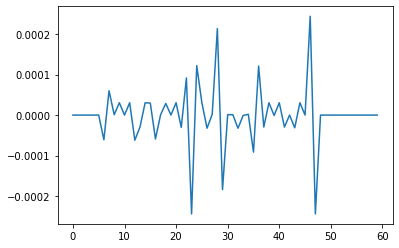

In [131]:
plt.plot(BoxSfr[3]-BoxSfr2[3])